# WeRateDogs Twiter
In this project I will be wrangling the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also known as WeRateDogs, to create interesting and trustworthy analyses and visualizations. With the final aim to answer these questions:
- 1. What dog breeds have the most number of likes among Twitter users?
- 2. What pictures of dog breeds have been most shared among Twitter users?
- 3. How do Twitter users refer most to their dogs?
- 4. Is there any particular attribute or object that makes a dog popular among Twitter users?¶

Importing necessary libraries:

In [1]:
import pandas as pd
pd.options.display.max_colwidth = None
import numpy as np 
import requests
import os
import tweepy
import json
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import re
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))

## Data Wrangling: 
### 1. Gathering Data: 
Data will be gathered from different resources:<br><br>
**a. File on hand:**

In [5]:
twt_archive = pd.read_csv("twitter-archive-enhanced.csv")
twt_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None


**b. Downloading File from the Internet** <br>
We will use the Requests get method which will send the request and return the content of the file we requested.

In [6]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
response

<Response [200]>

Response 200 is the HTTP status code that the request has succeeded.<br><br>
To save the file in my computer i have to open a new file which will then write the contents of the response variable.

In [7]:
with open (url.split("/")[-1], mode="wb") as file:
    file.write(response.content)

Check the contents of our folder to make sure it worked:

In [9]:
os.listdir()[2]

'image-predictions.tsv'

In [10]:
img_predict = pd.read_csv("image-predictions.tsv", sep = "\t")
img_predict.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


**c. Data from Twitter API**

In [23]:
with open('credentials.txt', "r") as file:
    lines = file.readlines()

In [24]:
consumer_key = lines[0]
consumer_secret = lines[1]
access_token = lines[2]
access_secret = lines[3]

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [25]:
twt_id = img_predict.tweet_id.values

In [70]:
n_count = 0
fails = {}

with open('tweet_json', 'w') as file:
    for ids in twt_id:
        n_count += 1
        try:
            tweet = api.get_status(ids, tweet_mode='extended')
            json.dump(tweet._json, file)
            file.write('\n')
        except tweepy.TweepError as wrong:
            fails[ids] = wrong
            pass

In [30]:
twt_json = pd.read_json("tweet_json", lines=True)
twt_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

## Assessing Data: 
### 1. twt_archive table: 
#### 1a. Visual Assessment: using Excel
#### 1b. Programatic assessment:

In [31]:
twt_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [32]:
twt_archive[["rating_numerator", "rating_denominator"]].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [33]:
twt_archive["rating_numerator"].sort_values(ascending=False).head(10)

979     1776
313      960
189      666
188      420
2074     420
1120     204
290      182
902      165
1779     144
1634     143
Name: rating_numerator, dtype: int64

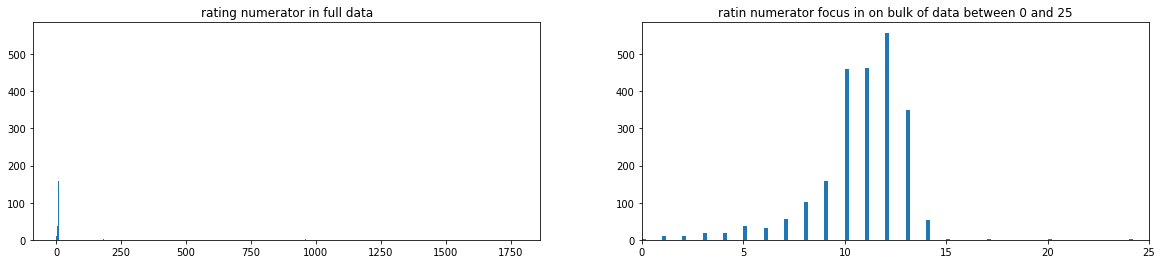

In [37]:
plt.figure(figsize = [20,4])

# histogram on left: "rating_numerator" full data
plt.subplot(1, 2, 1)
bins = np.arange(0, twt_archive.rating_numerator.max()+0.5, 0.5)
plt.hist(data=twt_archive, x='rating_numerator', bins=bins)
plt.title("rating numerator in full data");

# histogram on right: "ratin_numerator" focus in on bulk of data between 0 and 25
plt.subplot(1, 2, 2)
bins = np.arange(0, twt_archive.rating_numerator.max()+0.2, 0.2)
plt.hist(data=twt_archive, x='rating_numerator', bins=bins);
plt.xlim((0,25))
plt.title("ratin numerator focus in on bulk of data between 0 and 25");

In [35]:
twt_archive["rating_denominator"].sort_values(ascending=False).head()

1120    170
902     150
1634    130
1779    120
1635    110
Name: rating_denominator, dtype: int64

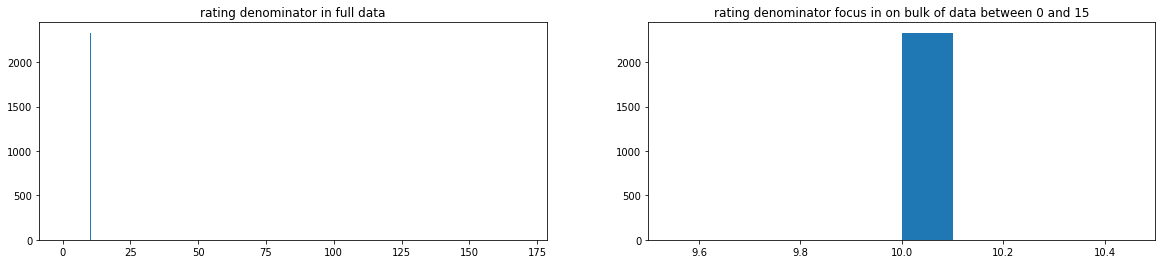

In [38]:
plt.figure(figsize = [20,4])

# histogram on left: "rating_denominator" full data
plt.subplot(1, 2, 1)
bins = np.arange(0, twt_archive.rating_denominator.max()+0.5, 0.5)
plt.hist(data=twt_archive, x='rating_denominator', bins=bins)
plt.title("rating denominator in full data");

# histogram on right: "ratin_numerator" focus in on bulk of data between 0 and 15
plt.subplot(1, 2, 2)
bins = np.arange(0, twt_archive.rating_denominator.max()+0.1, 0.1)
plt.hist(data=twt_archive, x='rating_denominator', bins=bins);
plt.xlim((9.5,10.5))
plt.title("rating denominator focus in on bulk of data between 0 and 15");

In [39]:
twt_archive.name.value_counts().head(20)

None       745
a           55
Charlie     12
Cooper      11
Oliver      11
Lucy        11
Tucker      10
Lola        10
Penny       10
Winston      9
Bo           9
Sadie        8
the          8
Toby         7
Bailey       7
Daisy        7
an           7
Buddy        7
Dave         6
Stanley      6
Name: name, dtype: int64

In [40]:
twt_archive.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

#### Qualitiy Issues:
- Column `timestamp` in wrong format.
- Some rows are duplicated due to _retweeted_status_id_.
- Columns `rating_numerator` and `rating_denominator` include wrong values (i.e. with _tweet_id: 883482846933004288, 810984652412424192_ and _666287406224695296_ ). 
- Column `names` sometimes includes wrong name (i.e. with _tweet_id: 776201521193218049_ ) and some are missing due to double reference in the text (i.e. _759793422261743616_ ).
- Values `rating_numerator` and `rating_denominator` have high values. Further investigation is required.
- Check some dog names in column `name` (like _a, the, and, this, not, mad, old, all, officially, my, O, by_ and many more).
#### Tidiness Issues:
- Some column names are a variable like dog stages (doggo, floofer, pupper and puppo).

## Cleaning `twt_archive` table:

In [41]:
twt_archive_clean = twt_archive.copy()

**Define:**
- Dropping rows containing *retweeted_status_id* and *in_reply_to_status_id* values due to duplication on information and names 

**Code:**

In [42]:
ind1 = twt_archive_clean[twt_archive_clean["retweeted_status_id"].notnull()].index
ind2 = twt_archive_clean[twt_archive_clean["in_reply_to_status_id"].notnull()].index

In [43]:
twt_archive_clean.drop(index=ind1, axis=0, inplace=True) # drop rows containing "retweeted_status_id"
twt_archive_clean.drop(index=ind2, axis=0, inplace=True) # drop rows containing "in_reply_to_status_id"
twt_archive_clean.reset_index(drop=True, inplace=True)

**Test:**

In [44]:
print("There are {} rows now, before there were {} number of rows" .format(twt_archive_clean.shape[0], twt_archive.shape[0]))

There are 2097 rows now, before there were 2356 number of rows


**Define:** 
- Dropping columns *in_reply_to_status_id, in_reply_to_user_id, source, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp* and *expanded_urls*

**Code:**

In [45]:
non_cols = [1,2,4,6,7,8,9]
twt_archive_clean.drop(twt_archive_clean.columns[non_cols], axis=1, inplace=True) # drop unnecessary columns

**Test:**

In [46]:
twt_archive_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

**Define:**
- Change format *timestamp* column from object to datetime and *tweet_id* column from int to string

**Code:**

In [47]:
twt_archive_clean["timestamp"] = pd.to_datetime(twt_archive_clean["timestamp"]).dt.tz_localize(None)
twt_archive_clean["tweet_id"] = twt_archive_clean["tweet_id"].astype(str)

**Test:**

In [48]:
twt_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2097 non-null   object        
 1   timestamp           2097 non-null   datetime64[ns]
 2   text                2097 non-null   object        
 3   rating_numerator    2097 non-null   int64         
 4   rating_denominator  2097 non-null   int64         
 5   name                2097 non-null   object        
 6   doggo               2097 non-null   object        
 7   floofer             2097 non-null   object        
 8   pupper              2097 non-null   object        
 9   puppo               2097 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 164.0+ KB


**Define:**
- Using regular expressions to extract correct *rating_numerator* and *rating_denominator* from *text* column

**Code:**

In [49]:
rating = twt_archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
rating.columns = ['rating_numerator', 'rating_denominator']
twt_archive_clean.rating_numerator = rating.rating_numerator
twt_archive_clean.rating_denominator = rating.rating_denominator

**Test:**

In [50]:
twt_archive_clean[["text","rating_numerator","rating_denominator"]].sample(5)

,text,rating_numerator,rating_denominator
2004,Here is George. George took a selfie of his new man bun and that is downright epic. (Also looks like Rand Paul) 9/10 https://t.co/afRtVsoIIb,9,10
1691,🎶 HELLO FROM THE OTHER SIIIIIIIIDE 🎶 10/10 https://t.co/MTOOksRzvH,10,10
602,This is Tucker. He would like a hug. 13/10 someone hug him https://t.co/wdgY9oHPrT,13,10
1119,Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu,10,10
1721,Magical floating dog here. Very calm. Always hangs by the pond. Rather moist. Good listener. 6/10 personally I'd pet https://t.co/1euKoOvy49,6,10


In [51]:
# Checking if "rating_numerator" and "rating_denominator" columns match values from "text" column: Yes
twt_archive_clean[["tweet_id","text","rating_numerator","rating_denominator"]].query('tweet_id == "883482846933004288"')

,tweet_id,text,rating_numerator,rating_denominator
41,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.5,10


In [52]:
# Checking if "rating_numerator" and "rating_denominator" columns match values from "text" column: Further cleaning needed
twt_archive_clean[["tweet_id","text","rating_numerator","rating_denominator"]].query('tweet_id == "810984652412424192"')

,tweet_id,text,rating_numerator,rating_denominator
403,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7


In [53]:
twt_archive_clean.loc[403,"rating_numerator"] = np.nan
twt_archive_clean.loc[403,"rating_denominator"] = np.nan
twt_archive_clean[["tweet_id","text","rating_numerator","rating_denominator"]].query('tweet_id == "810984652412424192"')

,tweet_id,text,rating_numerator,rating_denominator
403,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN


In [54]:
# Checking if "rating_numerator" and "rating_denominator" columns match values from "text" column: Further cleaning needed
twt_archive_clean[["tweet_id","text","rating_numerator","rating_denominator"]].query('tweet_id == "666287406224695296"')

,tweet_id,text,rating_numerator,rating_denominator
2076,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,2


In [55]:
text = twt_archive_clean.text.loc[2076]
ratings = re.findall('((?:\d+\.)?\d+)\/(\d+)', text)[1]
twt_archive_clean.loc[2076,"rating_numerator"] = ratings[0]
twt_archive_clean.loc[2076,"rating_denominator"] = ratings[1]
twt_archive_clean[["tweet_id","text","rating_numerator","rating_denominator"]].query('tweet_id == "666287406224695296"')

,tweet_id,text,rating_numerator,rating_denominator
2076,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,9,10


**Define:**
- Converting _rating_numerator_ and _rating_denominator_ columns to float types

**Code:**

In [56]:
twt_archive_clean.rating_numerator = twt_archive_clean.rating_numerator.astype(float)
twt_archive_clean.rating_denominator = twt_archive_clean.rating_denominator.astype(float)

**Test:**

In [57]:
twt_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2097 non-null   object        
 1   timestamp           2097 non-null   datetime64[ns]
 2   text                2097 non-null   object        
 3   rating_numerator    2096 non-null   float64       
 4   rating_denominator  2096 non-null   float64       
 5   name                2097 non-null   object        
 6   doggo               2097 non-null   object        
 7   floofer             2097 non-null   object        
 8   pupper              2097 non-null   object        
 9   puppo               2097 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 164.0+ KB


**Define:**
- Cleaning and extracting the correct names from _text_ column. 

**Code:**

In [58]:
a = []

for words,names in zip(twt_archive_clean.text ,twt_archive_clean.name):
    
    i = words.split()
     
    if words.startswith('This is ') and re.match(r'[A-Z].*', i[2]):
        a.append(i[2].strip('.').strip(','))
    
    elif 'This is' in words and re.match(r'[A-Z].*', i[(i.index("is") + 1)]):
        a.append(i[(i.index('is') + 1)].strip('.').strip(','))

    elif words.startswith('Here we have ') and re.match(r'[A-Z].*', i[3]):
        a.append(i[3].strip('.').strip(','))
        
    elif words.startswith('Say hello to ') and re.match(r'[A-Z].*',i[3]):
        a.append(i[3].strip('.').strip(',')) 
        
    elif words.startswith('Meet ') and re.match(r'[A-Z].*', i[1]):
        a.append(i[1].strip('.').strip(','))
        
    elif 'named' in words and re.match(r'[A-Z].*', i[(i.index('named') + 1)]): 
        a.append(i[(i.index('named') + 1)].strip('.').strip(','))
        
     # index 148: "Instead of the usual nightly dog rate, I'm sharing this story with you. Meeko is 13/10..."
    elif re.search("\.\s[A-Z].* is ((?:\d+\.)?\d+)\/(\d+)", words):     
        a.append(i[(i.index('is') - 1)].strip('.').strip(','))
        
    # index 308: "Here's a little more info on Dew, your favorite roaming doggo..."
    elif 'more info on ' in words and re.match(r'[A-Z].*', i[(i.index("on") + 1)]):
        a.append(i[(i.index('on') + 1)].strip('.').strip(','))
         
    # index 382: "Here is Atlas. He went all out this year."
    elif 'Here is ' in words and re.match(r'[A-Z].*', i[(i.index("is") + 1)]):
        a.append(i[(i.index('is') + 1)].strip('.').strip(','))

    # index 657: "This is my dog. Her name is Zoey. She knows I've been rating other dogs."
    elif words.startswith('Her name is ', 16) and re.match(r'[A-Z].*', i[7]):
        a.append(i[7].strip('.').strip(','))
        
    else:
        a.append("No Name")
        
    twt_archive_clean["names"] = pd.Series(a)

**Test:**

In [60]:
twt_archive_clean[["text","name","names"]].sample(5)

,text,name,names
1652,This is Rodman. He's getting destroyed by the surfs. Valiant effort though. 10/10 better than most puppers probably https://t.co/S8wCLemrNb,Rodman,Rodman
599,This girl straight up rejected a guy because he doesn't like dogs. She is my hero and I give her 13/10 https://t.co/J39lT3b0rH,None,No Name
2075,This is a funny dog. Weird toes. Won't come down. Loves branch. Refuses to eat his food. Hard to cuddle with. 3/10 https://t.co/IIXis0zta0,a,No Name
2047,These are Peruvian Feldspars. Their names are Cupit and Prencer. Both resemble Rand Paul. Sick outfits 10/10 &amp; 10/10 https://t.co/ZnEMHBsAs1,None,No Name
969,Get you a pup that can do both. 10/10 https://t.co/zSbyvm62xZ,None,No Name


In [61]:
# Checking if "names" column matches values from "text" column: Yes
twt_archive_clean[twt_archive_clean["tweet_id"].str.contains("666983947667116034")]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names
2045,666983947667116034,2015-11-18 14:18:59,This is a curly Ticonderoga named Pepe. No feet. Loves to jet ski. 11/10 would hug until forever https://t.co/cyDfaK8NBc,11.0,10.0,a,None,None,None,None,Pepe


In [62]:
# Checking if "names" column matches values from "text" column: Yes
twt_archive_clean[twt_archive_clean["tweet_id"].str.contains("776201521193218049")]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names
594,776201521193218049,2016-09-14 23:30:38,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC,10.0,10.0,O,None,None,None,None,O'Malley


**Define:**
- Extracting and creating *dog_stage* column from *text*. 

**Code:**

In [63]:
# Handling none
twt_archive_clean.doggo.replace('None', '', inplace=True) 
twt_archive_clean.floofer.replace('None', '', inplace=True) 
twt_archive_clean.pupper.replace('None', '', inplace=True) 
twt_archive_clean.puppo.replace('None', '', inplace=True)

In [64]:
# Merge into column "dog_stage"
twt_archive_clean['dog_stage'] = twt_archive_clean.doggo + twt_archive_clean.floofer + twt_archive_clean.pupper + twt_archive_clean.puppo

In [65]:
# Handling multiple stages
twt_archive_clean.loc[twt_archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper' 
twt_archive_clean.loc[twt_archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo' 
twt_archive_clean.loc[twt_archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

In [66]:
# Handling missing values
twt_archive_clean.loc[twt_archive_clean.dog_stage == '', 'dog_stage'] = np.nan

In [67]:
# Dropping last unnecessary columns
twt_archive_clean.drop(["name","doggo","floofer","pupper","puppo"], axis=1, inplace=True)

**Test:**

In [68]:
twt_archive_clean.sample(5)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,names,dog_stage
404,810896069567610880,2016-12-19 17:14:23,"This is Hunter. He just found out he needs braces. Requesting an orthodogtist stat. 11/10 you're fine Hunter, everything's fine https://t.co/zW1o0W4AYV",11.0,10.0,Hunter,NaN
1648,674739953134403584,2015-12-09 23:58:35,"""🎶 DO YOU BELIEVE IN LIFE AFTER LOVE 🎶""\n11/10 https://t.co/URNs5zFskc",11.0,10.0,No Name,NaN
1444,681981167097122816,2015-12-29 23:32:35,This is Jimothy. He's a Trinidad Poliwhirl. Father was a velociraptor. Exceptionally unamused. 12/10 would adopt https://t.co/VwdIk0OwVx,12.0,10.0,Jimothy,NaN
2070,666373753744588802,2015-11-16 21:54:18,Those are sunglasses and a jean jacket. 11/10 dog cool af https://t.co/uHXrPkUEyl,11.0,10.0,No Name,NaN
2048,666826780179869698,2015-11-18 03:54:28,12/10 simply brilliant pup https://t.co/V6ZzG45zzG,12.0,10.0,No Name,NaN


## Assessing Data: 
### 2. img_predict table: 
#### 2.a Visual Assessment :

In [61]:
img_predict.sample(7)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2011,879008229531029506,https://pbs.twimg.com/media/DDLdUrqXYAMOVzY.jpg,1,vizsla,0.960513,True,miniature_pinscher,0.009431,True,American_Staffordshire_terrier,0.008711,True
590,679148763231985668,https://pbs.twimg.com/media/CWzSMmAWsAAyB1u.jpg,1,Italian_greyhound,0.302685,True,hair_slide,0.124281,False,Afghan_hound,0.059846,True
44,666781792255496192,https://pbs.twimg.com/media/CUDigRXXIAATI_H.jpg,1,Italian_greyhound,0.618316,True,Weimaraner,0.151363,True,vizsla,0.085989,True
1387,766078092750233600,https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg,1,toy_poodle,0.420463,True,miniature_poodle,0.132640,True,Chesapeake_Bay_retriever,0.121523,True
456,674774481756377088,https://pbs.twimg.com/media/CV1HztsWoAAuZwo.jpg,1,Chihuahua,0.407016,True,French_bulldog,0.309978,True,Siamese_cat,0.227677,False
260,670783437142401025,https://pbs.twimg.com/media/CU8Z-OxXAAA-sd2.jpg,1,lacewing,0.381955,False,sulphur_butterfly,0.106810,False,leafhopper,0.068347,False
1249,747844099428986880,https://pbs.twimg.com/media/CmDgPTsWEAIi2T1.jpg,1,Pembroke,0.360428,True,papillon,0.263134,True,Chihuahua,0.131246,True


#### 2b. Programatic assessment:

In [52]:
img_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [53]:
# Function that takes a data frame as input and returns another data frame where each feature 
# of the original data frame is a row and the summary statistics are columns. 
def stats(df):
    img_stats = {}
    img_stats["null_sum"] = df.isnull().sum()
    img_stats["null_percent"] = df.isnull().mean()
    img_stats["dtypes"] = df.dtypes
    img_stats["count"] = df.count()
    img_stats["mean"] = df.mean()
    img_stats["median"] = df.median()
    img_stats["unique"] = df.nunique()
    img_stats["min"] = df.min()
    img_stats["max"] = df.max()
    
    return pd.DataFrame(img_stats)

In [54]:
stats(img_predict)

,null_sum,null_percent,dtypes,count,mean,median,unique,min,max
img_num,0,0.0,int64,2075,1.203855e+00,1.000000e+00,4,1,4
jpg_url,0,0.0,object,2075,NaN,NaN,2009,https://pbs.twimg.com/ext_tw_video_thumb/674805331965399040/pu/img/-7bw8niVrgIkLKOW.jpg,https://pbs.twimg.com/tweet_video_thumb/CtTFZZfUsAE5hgp.jpg
p1,0,0.0,object,2075,NaN,NaN,378,Afghan_hound,zebra
p1_conf,0,0.0,float64,2075,5.945483e-01,5.882300e-01,2006,0.0443334,1
p1_dog,0,0.0,bool,2075,7.383133e-01,1.000000e+00,2,False,True
p2,0,0.0,object,2075,NaN,NaN,405,Afghan_hound,wood_rabbit
p2_conf,0,0.0,float64,2075,1.345886e-01,1.181810e-01,2004,1.0113e-08,0.488014
p2_dog,0,0.0,bool,2075,7.484337e-01,1.000000e+00,2,False,True
p3,0,0.0,object,2075,NaN,NaN,408,Afghan_hound,zebra
p3_conf,0,0.0,float64,2075,6.032417e-02,4.944380e-02,2006,1.74017e-10,0.273419


In [55]:
# Check and take duplicates from "jpg_url" column
mask = img_predict.duplicated(subset=["jpg_url"]) 
img_predict[mask].head(7)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
1364,761371037149827077,https://pbs.twimg.com/tweet_video_thumb/CeBym7oXEAEWbEg.jpg,1,brown_bear,0.713293,False,Indian_elephant,0.172844,False,water_buffalo,0.038902,False
1368,761750502866649088,https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg,1,golden_retriever,0.586937,True,Labrador_retriever,0.398260,True,kuvasz,0.005410,True


In [56]:
img_predict[mask].shape # there are 66 links that are duplicates. Further investigation is required

(66, 12)

In [57]:
# As an example
img_predict[img_predict.jpg_url.str.contains("https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg")] 

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
591,679158373988876288,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.25153,True,bath_towel,0.116806,False
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.25153,True,bath_towel,0.116806,False


#### Qualitiy Issues:
- Prediction values (in _p1, p2_ and _p3_ columns) should all start with capital letter.
- Values in _p1, p2_ and _p3_ should not have an underscore (\_) between words.
- Values in _p1_conf, p2_conf,_ and _p3_conf_ should be rounded up to 3 decimal points. 
- Column _jpg_url_ has same link (dulplicates) belonging to two different _tweet_id_. To be check after merging with other tables.
- Due to compatibility reasons, the column _tweet_id_ should be in string format.

## Cleaning `img_predict` table:

In [58]:
img_predict_clean = img_predict.copy()

**Define:** 
- Cleaning values in _p1, p2_ and _p3_ columns

**Code:**

In [59]:
img_predict_clean.p1 = [i.replace("_"," ").capitalize() for i in img_predict_clean.p1]
img_predict_clean.p2 = [i.replace("_"," ").capitalize() for i in img_predict_clean.p2]
img_predict_clean.p3 = [i.replace("_"," ").capitalize() for i in img_predict_clean.p3]

**Test:**

In [76]:
img_predict_clean[["p1","p2","p3"]].head()

,p1,p2,p3
0,Welsh springer spaniel,Collie,Shetland sheepdog
1,Redbone,Miniature pinscher,Rhodesian ridgeback
2,German shepherd,Malinois,Bloodhound
3,Rhodesian ridgeback,Redbone,Miniature pinscher
4,Miniature pinscher,Rottweiler,Doberman


**Define:** 
- Converting _tweet_id_ column from int to string format

**Code:**

In [61]:
img_predict_clean["tweet_id"] = img_predict_clean["tweet_id"].astype(str)

**Test:**

In [63]:
img_predict_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


**Define:** 
- Rounding values in _p1_conf, p2_conf_, and _p3_conf_

**Code:**

In [64]:
img_predict_clean.p1_conf = img_predict_clean.p1_conf.round(3)
img_predict_clean.p2_conf = img_predict_clean.p2_conf.round(3)
img_predict_clean.p3_conf = img_predict_clean.p3_conf.round(3)

**Test:**

In [65]:
img_predict_clean.sample(6)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1477,780543529827336192,https://pbs.twimg.com/media/CtUMLzRXgAAbZK5.jpg,1,Golden retriever,0.628,True,Labrador retriever,0.317,True,Tibetan mastiff,0.012,True
1940,860924035999428608,https://pbs.twimg.com/media/C_KVJjDXsAEUCWn.jpg,2,Envelope,0.933,False,Oscilloscope,0.013,False,Paper towel,0.011,False
988,707776935007539200,https://pbs.twimg.com/media/CdKHWimWoAABs08.jpg,1,Miniature pinscher,0.890,True,Toy terrier,0.051,True,Chihuahua,0.018,True
361,672828477930868736,https://pbs.twimg.com/media/CVZd7ttWcAEs2wP.jpg,1,Sandbar,0.118,False,Stingray,0.076,False,Seashore,0.075,False
2000,876120275196170240,https://pbs.twimg.com/media/DCiavj_UwAAcXep.jpg,1,Bernese mountain dog,0.534,True,Saint bernard,0.346,True,Greater swiss mountain dog,0.095,True
2013,879376492567855104,https://pbs.twimg.com/media/DDQsQGFV0AAw6u9.jpg,1,Tricycle,0.664,False,Labrador retriever,0.033,True,Pembroke,0.019,True


## Assessing Data: 
### 3. twt_json_clean: 
#### 3a. Visual assessment: using Excel 
#### 3b. Programmatic assessment:

In [69]:
twt_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

In [50]:
twt_json.describe()

,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,geo,coordinates,contributors,retweet_count,favorite_count
count,2.059000e+03,2.059000e+03,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01,0.0,0.0,0.0,2059.000000,2059.000000
mean,7.378345e+17,7.378345e+17,6.978112e+17,6.978112e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,2503.570180,7793.842642
std,6.758411e+16,6.758411e+16,4.359384e+16,4.359384e+16,0.000000e+00,0.000000e+00,NaN,NaN,NaN,4375.370721,11779.534604
min,6.660209e+17,6.660209e+17,6.671522e+17,6.671522e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,11.000000,0.000000
25%,6.762505e+17,6.762505e+17,6.732411e+17,6.732411e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,536.000000,1479.000000
50%,7.113067e+17,7.113067e+17,6.757073e+17,6.757073e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,1183.000000,3436.000000
75%,7.928986e+17,7.928986e+17,7.031489e+17,7.031489e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,2874.500000,9706.000000
max,8.924206e+17,8.924206e+17,8.558181e+17,8.558181e+17,4.196984e+09,4.196984e+09,NaN,NaN,NaN,75234.000000,152175.000000


#### Qualitiy Issues:
- Too many unnecessary columns. I need information from _id, retweet_count_ and _favorite_count_ columns.
- Due to compatibility reasons, the column _id_ should be in string format.

#### Tidiness Issues:
- Values in _retweet_count_ and _favorite_count_ columns are part of an observational unit. Therefore, they should form a table with more information about _id_. 

## Cleaning `twt_json` table:

In [66]:
twt_json_clean = twt_json.copy()

**Define:**
- converting _id_ column to string type and creating a new dataframe with just necessary information

**Code:**

In [67]:
twt_json_clean["id"] = twt_json_clean["id"].astype(str) 
twt_json_clean = twt_json_clean[["id","retweet_count","favorite_count"]] 

**Test:**

In [68]:
twt_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2059 non-null   object
 1   retweet_count   2059 non-null   int64 
 2   favorite_count  2059 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 48.4+ KB


In [69]:
twt_json_clean.head()

,id,retweet_count,favorite_count
0,666020888022790149,447,2357
1,666029285002620928,41,118
2,666033412701032449,39,108
3,666044226329800704,124,263
4,666049248165822465,39,95


**Define:**
- Merging all tables to have a tidy observational unit. 

**Code:**

In [70]:
result = pd.merge(twt_archive_clean, twt_json_clean, how="inner", left_on = "tweet_id", right_on="id")

In [71]:
total_result = pd.merge(result, img_predict_clean, how="inner", on = "tweet_id")
total_result.drop("id", axis=1, inplace=True)

**Test:**

In [72]:
total_result.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,names,dog_stage,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13.0,10.0,Phineas,NaN,7455,35308,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,Orange,0.097,False,Bagel,0.086,False,Banana,0.076,False
1,892177421306343426,2017-08-01 00:17:27,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13.0,10.0,Tilly,NaN,5535,30556,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.324,True,Pekinese,0.091,True,Papillon,0.069,True
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12.0,10.0,Archie,NaN,3660,23001,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716,True,Malamute,0.078,True,Kelpie,0.031,True
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13.0,10.0,Darla,NaN,7628,38600,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Paper towel,0.170,False,Labrador retriever,0.168,True,Spatula,0.041,False
4,891327558926688256,2017-07-29 16:00:24,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12.0,10.0,Franklin,NaN,8223,36887,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset,0.556,True,English springer,0.226,True,German short-haired pointer,0.175,True


In [73]:
total_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1964 non-null   object        
 1   timestamp           1964 non-null   datetime64[ns]
 2   text                1964 non-null   object        
 3   rating_numerator    1963 non-null   float64       
 4   rating_denominator  1963 non-null   float64       
 5   names               1964 non-null   object        
 6   dog_stage           302 non-null    object        
 7   retweet_count       1964 non-null   int64         
 8   favorite_count      1964 non-null   int64         
 9   jpg_url             1964 non-null   object        
 10  img_num             1964 non-null   int64         
 11  p1                  1964 non-null   object        
 12  p1_conf             1964 non-null   float64       
 13  p1_dog              1964 non-null   bool        

In [74]:
stats(total_result)

,null_sum,null_percent,dtypes,count,mean,median,unique,min,max
dog_stage,1662,0.846232,object,302,NaN,NaN,7,NaN,NaN
favorite_count,0,0.000000,int64,1964,8125.425153,3.668000e+03,1801,69,152175
img_num,0,0.000000,int64,1964,1.202138,1.000000e+00,4,1,4
jpg_url,0,0.000000,object,1964,NaN,NaN,1964,https://pbs.twimg.com/ext_tw_video_thumb/674805331965399040/pu/img/-7bw8niVrgIkLKOW.jpg,https://pbs.twimg.com/tweet_video_thumb/CeBym7oXEAEWbEg.jpg
names,0,0.000000,object,1964,NaN,NaN,935,Abby,Zuzu
p1,0,0.000000,object,1964,NaN,NaN,373,Acorn squash,Zebra
p1_conf,0,0.000000,float64,1964,0.593919,5.870000e-01,805,0.044,1
p1_dog,0,0.000000,bool,1964,0.741344,1.000000e+00,2,False,True
p2,0,0.000000,object,1964,NaN,NaN,396,Academic gown,Yorkshire terrier
p2_conf,0,0.000000,float64,1964,0.134637,1.170000e-01,381,0,0.488


**Saving** my clean data as **twitter_archive_master.csv**

In [66]:
total_result.to_csv('twitter_archive_master.csv', index=False)

# Analysing `twiter_archive_master` table

In [5]:
master = pd.read_csv("twitter_archive_master.csv")
master.sample(3)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,names,dog_stage,retweet_count,favorite_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1594,672988786805112832,2015-12-05 04:00:04,This is Schnozz. He's had a blurred tail since birth. Hasn't let that stop him. 10/10 inspirational pupper https://t.co/a3zYMcvbXG,10.0,10.0,Schnozz,pupper,267,921,https://pbs.twimg.com/media/CVbvjKqW4AA_CuD.jpg,1,Lakeland terrier,0.837,True,West highland white terrier,0.074,True,Wire-haired fox terrier,0.038,True
1217,688804835492233216,2016-01-17 19:27:24,When you stumble but recover quickly cause your crush is watching. 12/10 https://t.co/PMeq6IedU7,12.0,10.0,No Name,NaN,184,941,https://pbs.twimg.com/media/CY8gWFRWUAAm1XL.jpg,3,Malinois,0.200,True,German shepherd,0.097,True,Saluki,0.083,True
624,762316489655476224,2016-08-07 15:56:28,This is Scout. He specializes in mid-air freeze frames. 11/10 https://t.co/sAHmwRtfSq,11.0,10.0,Scout,NaN,1089,4713,https://pbs.twimg.com/media/CpRKzZKWAAABGh7.jpg,1,African grey,0.270,False,Madagascar cat,0.076,False,Television,0.033,False


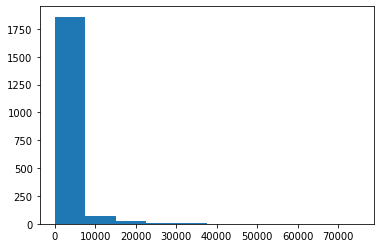

In [22]:
plt.hist(master.retweet_count); # Distribution of "retweet_count"

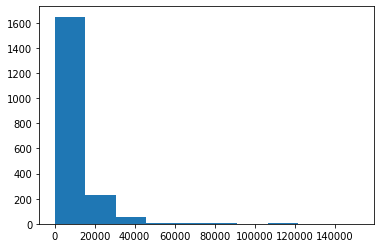

In [23]:
plt.hist(master.favorite_count); # Distribution of "favorite_count"

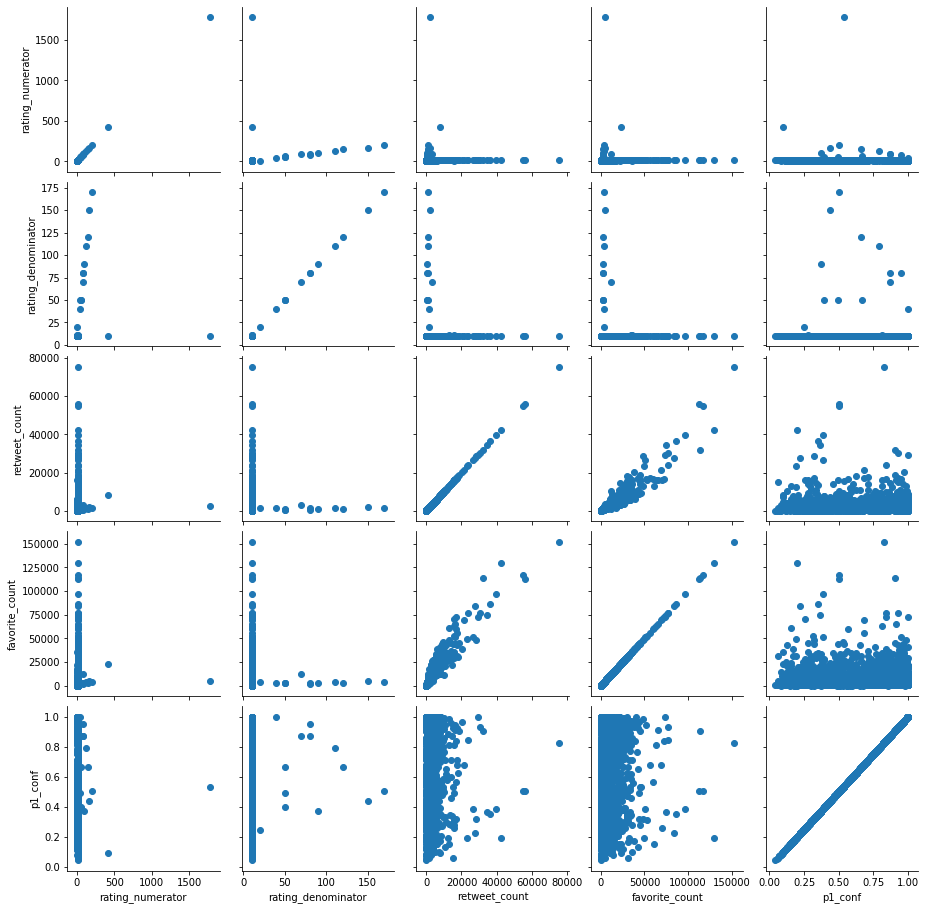

In [8]:
stats = ["rating_numerator","rating_denominator", "retweet_count", "favorite_count", "p1_conf"]
g = sb.PairGrid(data = master, vars = stats)
g.map(plt.scatter);

Interested to notice the positive correlation between _rating_numerator_ and _rating_denominator_, and between _favorite_count_ and _retweet_count_. 

## 1. What dog breeds have the most number of likes among Twitter users?

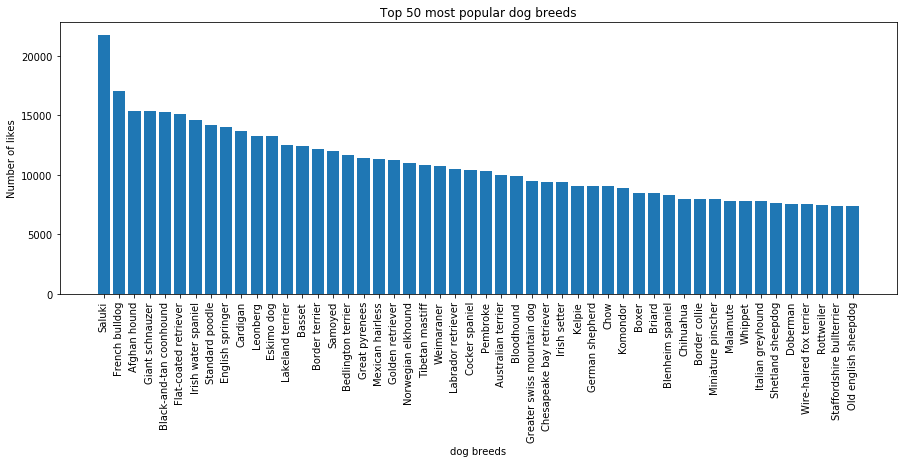

In [164]:
breeds = master[master["p1_dog"] == True]
top_50_likes = breeds.groupby(["p1"])["favorite_count"].mean().sort_values(ascending=False).reset_index().head(50)

plt.figure(figsize = [15,5])
plt.bar(data= top_50_likes, height= "favorite_count", x= "p1")
plt.xticks(rotation = 90);
plt.xlabel("dog breeds")
plt.ylabel("Number of likes")
plt.title("Top 50 most popular dog breeds");

## 2. What pictures of dog breeds have been most shared among Twitter users?

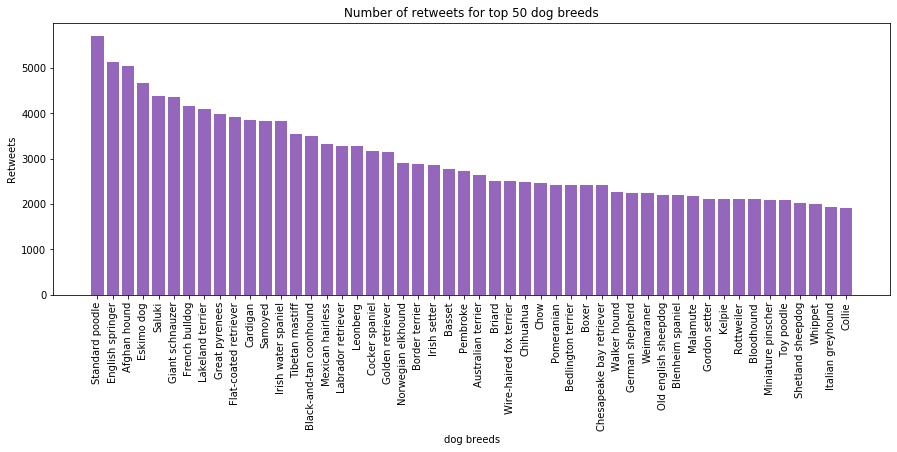

In [165]:
top_50_ret = breeds.groupby(["p1"])["retweet_count"].mean().sort_values(ascending=False).reset_index().head(50)

plt.figure(figsize = [15,5])
plt.bar(data= top_50_ret, height= "retweet_count", x= "p1", color=sb.color_palette()[4])
plt.xticks(rotation = 90);
plt.xlabel("dog breeds")
plt.ylabel("Retweets")
plt.title("Number of retweets for top 50 dog breeds");

## 3. How do Twitter users refer most to their dogs?

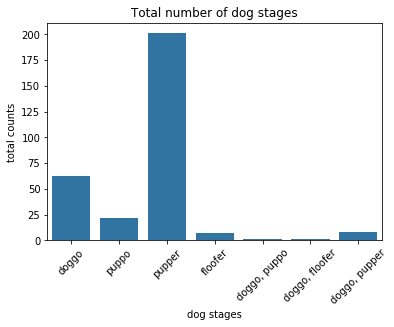

In [202]:
sb.countplot(data = master, x = "dog_stage", color=sb.color_palette()[0])
plt.xticks(rotation = 45);
plt.ylabel("total counts")
plt.xlabel("dog stages")
plt.title("Total number of dog stages");

## 4. Is there any particular attribute or object that makes a dog popular among Twitter users?

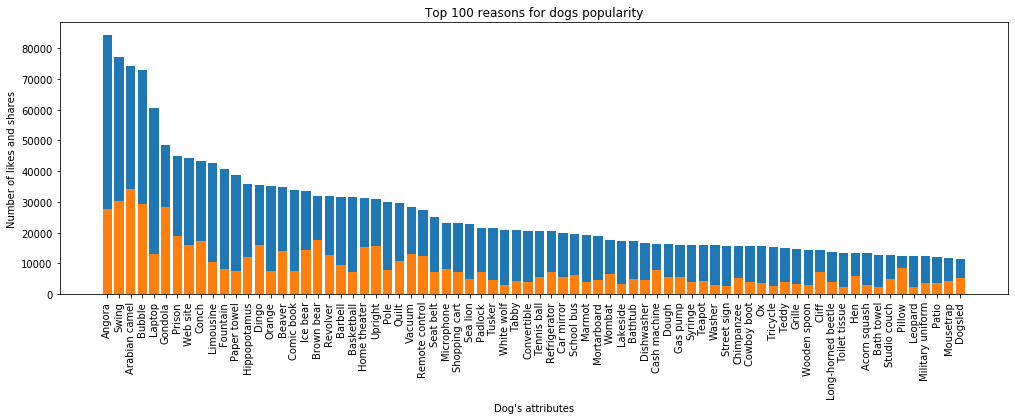

In [9]:
no_breeds = master[master["p1_dog"] == False]
top_100 = no_breeds[["p1","favorite_count", "retweet_count"]].sort_values(by=["favorite_count"], ascending=False).head(100)

plt.figure(figsize = [17,5])
plt.bar(data= top_100, height= "favorite_count", x= "p1")
plt.bar(data= top_100, height= "retweet_count", x= "p1")
plt.xticks(rotation = 90);
plt.xlabel("Dog's attributes")
plt.ylabel("Number of likes and shares")
plt.title("Top 100 reasons for dogs popularity");